# Run 4 : MLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Word2Vec
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### Chargement des données d'apprentissage et de test

In [2]:
df_train = pd.read_csv("../data/train.csv", sep=',', encoding='utf-8')
df_validation = pd.read_csv("../data/validation.csv", sep=',', encoding='utf-8')
df_test = pd.read_csv("../data/test.csv", sep=',', encoding='utf-8')

### Vectorisation des données avec Word2Vec et encodage des labels

In [3]:
stop_words = set(stopwords.words('french'))

df_train['vecteur'] = df_train['titre'] + " " + df_train['recette']
df_validation['vecteur'] = df_validation['titre'] + " " + df_validation['recette']
df_test['vecteur'] = df_test['titre'] + " " + df_test['recette']

# tokenisation 
def tokenize_text(text):
    tokens = word_tokenize(text, language="french")
    mal_segmentes = [t for t in tokens if "'" in t]
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df_train['tokenize_text'] = df_train['vecteur'].apply(tokenize_text)
df_validation['tokenize_text'] = df_validation['vecteur'].apply(tokenize_text)
df_test['tokenize_text'] = df_test['vecteur'].apply(tokenize_text)

# modèle Word2Vec 
model = Word2Vec(sentences=df_train['tokenize_text'], vector_size=100, window=5, min_count=1, workers=4)

# vecteur pour une phrase
def get_vector(words, model):
    words = [word for word in words if word in model.wv]
    return np.mean(model.wv[words], axis=0)

# transformation en vecteur 
x_train = np.array(df_train['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())
x_validation = np.array(df_validation['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())
x_test = np.array(df_test['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["type"])
y_validation = label_encoder.transform(df_validation["type"])
y_test = label_encoder.transform(df_test["type"])

### Conversion des données en tensors PyTorch

In [4]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_validation = torch.tensor(x_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [5]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)

validation_dataset = TensorDataset(x_validation, y_validation)
validation_loader = DataLoader(validation_dataset, batch_size=150, shuffle=False)

### Affichage des tailles des tensors pour adapter la taille du modèles

In [6]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

torch.Size([11225, 100]) torch.Size([11225])
torch.Size([1248, 100]) torch.Size([1248])
torch.Size([1388, 100]) torch.Size([1388])


### Modèle

In [7]:
device = torch.device('cpu')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Linear(100, 256) # 256 neurones 
        self.c2 = nn.Linear(256, 256) 
        self.c3 = nn.Linear(256, 3) 
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.c1(x))
        x = self.activation(self.c2(x))
        x = self.c3(x)
        return x

model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(dataloader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for batch, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(x.to(device))
        loss = criterion(pred, y.to(device))

        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            train_loss += loss.item()
    return train_loss/100

def test(dataloader, model, criterion):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x.to(device))
            test_loss += criterion(pred, y.to(device)).item()
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y.to(device)).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

### Entraînement

In [9]:
loss_train = []
loss_validation = []
for epochs in range(15):
    current_loss = 0.0
    print(f"Epoch {epochs + 1}")
    loss_train.append(train(train_loader, model, criterion, optimizer))
    loss_validation.append(test(validation_loader, model, criterion))

Epoch 1
Accuracy: 84.9%, Avg loss: 0.329440 

Epoch 2
Accuracy: 84.8%, Avg loss: 0.343256 

Epoch 3
Accuracy: 84.9%, Avg loss: 0.328948 

Epoch 4
Accuracy: 85.7%, Avg loss: 0.329562 

Epoch 5
Accuracy: 85.5%, Avg loss: 0.339222 

Epoch 6
Accuracy: 85.7%, Avg loss: 0.340523 

Epoch 7
Accuracy: 83.7%, Avg loss: 0.350721 

Epoch 8
Accuracy: 85.7%, Avg loss: 0.328926 

Epoch 9
Accuracy: 84.8%, Avg loss: 0.347392 

Epoch 10
Accuracy: 85.3%, Avg loss: 0.349785 

Epoch 11
Accuracy: 84.2%, Avg loss: 0.357041 

Epoch 12
Accuracy: 83.0%, Avg loss: 0.371821 

Epoch 13
Accuracy: 84.0%, Avg loss: 0.362125 

Epoch 14
Accuracy: 84.3%, Avg loss: 0.357657 

Epoch 15
Accuracy: 85.2%, Avg loss: 0.343119 



#### Graphique des pertes

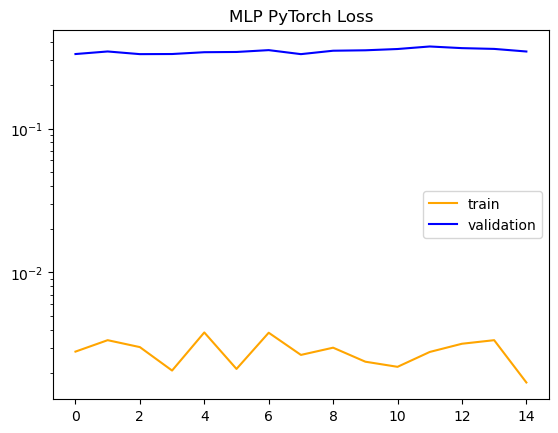

In [11]:
x = pd.Series(range(15))
plt.figure()
plt.plot(x, loss_train, color='orange')
plt.plot(x, loss_validation, color='blue')
plt.legend(['train', 'validation'])
plt.yscale('log')
plt.title("MLP PyTorch Loss")
plt.show()

### Prédiction

In [12]:
with torch.no_grad():
    y_pred = model(x_test.to(device))

y_pred_classes = torch.argmax(y_pred, dim=1)

### Résultats

In [13]:
score = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", score, "\n")
print(classification_report(y_test, y_pred_classes), "\n")

Accuracy: 0.8422190201729106 

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       407
           1       0.72      0.63      0.67       337
           2       0.82      0.87      0.84       644

    accuracy                           0.84      1388
   macro avg       0.84      0.82      0.83      1388
weighted avg       0.84      0.84      0.84      1388
 



<Axes: >

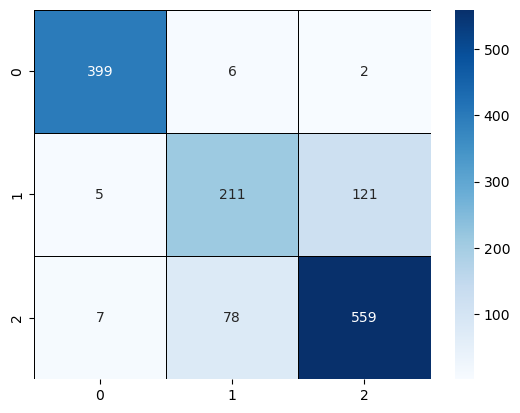

In [15]:
import seaborn as sns 
matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")